Archivos: census_train.csv, census_test.csv
Este conjunto de datos es una versión modificada del utilizado en el artículo [Scaling Up the
Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf), escrito por Ron Kohavi. Los datos originales se pueden encontrar en el [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

El objetivo es predecir si los ingresos de una persona superan o no los 50.000$ (variable
income). Para ello, se tienen 13 características:

* age: Edad
* workclass: tipo de ocupación (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked)
* education_level: Nivel educativo (Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool)
* education-num: Número de años de educación completados.
* marital-status: estado civil (Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse)
* occupation: ocupación (Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces)
* relationship: familia (Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried)
* race : ​ raza (White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black)
* sex ​ : Género (Female, Male)
* capital-gain : ​ Ganancia de capitales
* capital-loss : ​ Pérdida de capitales
* hours-per-week ​ : Promedio de horas trabajadas por semana
* native-country : ​ País de origen (United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinidad&Tobago, Peru, Hong, Holand-Netherlands)

### Realizamos los imports necesarios y creamos las funciones necesarias

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [3]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

### Análisis exploratorio

In [4]:
# cargamos el fichero de datos y mostramos las primeras filas para tomar una primera impresión de los datos
data = pd.read_csv('https://github.com/ivanrumo/KC_Practica_Machine_Learning/blob/master/data/census_train.csv?raw=true')#'data/census_train.csv')
data.head(10)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,Masters,14.0,Divorced,Sales,Unmarried,Other,Female,0.0,0.0,20.0,Peru,<=50K
1,43,Private,Assoc-acdm,12.0,Divorced,Craft-repair,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
2,53,Private,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,99999.0,0.0,37.0,United-States,>50K
3,23,Private,HS-grad,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,3908.0,0.0,40.0,United-States,<=50K
4,32,Private,Some-college,10.0,Divorced,Handlers-cleaners,Unmarried,Black,Male,0.0,0.0,40.0,Nicaragua,<=50K
5,29,Federal-gov,Some-college,10.0,Married-spouse-absent,Adm-clerical,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
6,51,Private,Some-college,10.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
7,33,Self-emp-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
8,35,Local-gov,Masters,14.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
9,39,Private,Some-college,10.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K


Vemos algunas variables que pueden ser categóricas, algunos valores aprimera vista dispares, etc.
education_level y education-num parece que representan la mismo información. 

In [5]:
data.shape

(36177, 14)

vemos que tenemos 13 variables (+ la objetivo) y mas de 36.000 muestras

In [6]:
data['income'].value_counts()

<=50K    27211
>50K      8966
Name: income, dtype: int64

La variable está desbalanceada. **Mas del 75% gana menos de $50K**

In [7]:
data.dtypes

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

confirmamos que tenemos varias variables de texto y tenemos que explorar sus valores para comprobar si con categóricas

In [8]:
data.isnull().any()

age                False
workclass          False
education_level    False
education-num      False
marital-status     False
occupation         False
relationship       False
race               False
sex                False
capital-gain       False
capital-loss       False
hours-per-week     False
native-country     False
income             False
dtype: bool

por suerte no tenemos valores nulos

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36177.0,38.598751,13.229011,17.0,28.0,37.0,47.0,90.0
education-num,36177.0,10.113663,2.553911,1.0,9.0,10.0,13.0,16.0
capital-gain,36177.0,1088.861735,7506.099972,0.0,0.0,0.0,0.0,99999.0
capital-loss,36177.0,88.133206,404.279205,0.0,0.0,0.0,0.0,4356.0
hours-per-week,36177.0,40.881582,11.981588,1.0,40.0,40.0,45.0,99.0


Las variables capital-gain, capital-loss y hours-per-week tienen valores máximos muy altos. 
Tengo que comprobar mas adelante si tenemos outliers

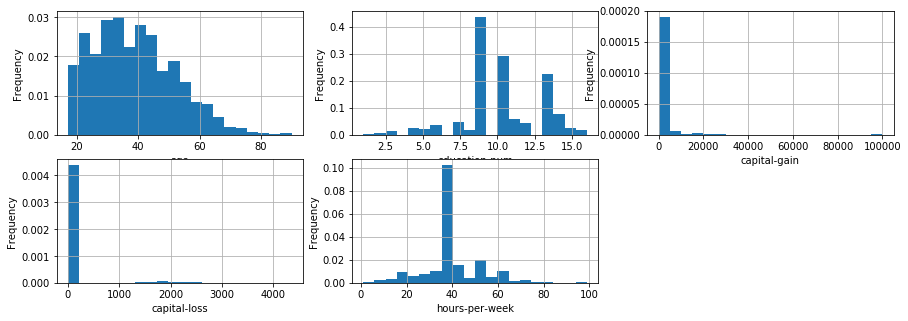

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(2,3,1)
data['age'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('age')

plt.subplot(2,3,2)
data['education-num'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('education-num')

plt.subplot(2,3,3)
data['capital-gain'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('capital-gain')

plt.subplot(2,3,4)
data['capital-loss'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('capital-loss')

plt.subplot(2,3,5)
data['hours-per-week'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('hours-per-week')

plt.show()

**age** Vemos una distribución normal. Tenemos algunos valores muy altos poco representativos. 

**education-num** Los valores entre 9 y 13 son los mas abundantes

**capital-gain** y **capital-loss** en la mayoría de casos su valor es cero. Es posible que estas variables no tengan que estar en el modelo. Más adelante lo podré comprobar.

**hours-per-week** como es lógico alrrededor de las 40 horas semanales es el valor predominante. 

In [11]:
print("% capital-gain valores = 0: {}".format(data[(data['capital-gain'] == 0)].shape[0] / data.shape[0]))
print("% capital-loss valores = 0: {}".format(data[(data['capital-loss'] == 0)].shape[0] / data.shape[0]))
print("% capital-gain y capital-loss ambos valores = 0: {}".format(data[(data['capital-gain'] == 0) & (data['capital-loss'] == 0)].shape[0] / data.shape[0]))

% capital-gain valores = 0: 0.9175719379716394
% capital-loss valores = 0: 0.9529811758852309
% capital-gain y capital-loss ambos valores = 0: 0.8705531138568704


Para capital gain mas del 90% de los valores es 0

En el caso de capital loss es mas del 95%

Ambas variables tienen como valor 0 en el 87% de las muestras.

Seguramente estas variables deban eliminarse. Por ahora las mantengo y en función de los resultados de los modelos barajaré sacar las variables para entrenar los modelos.

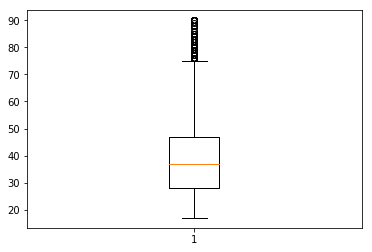

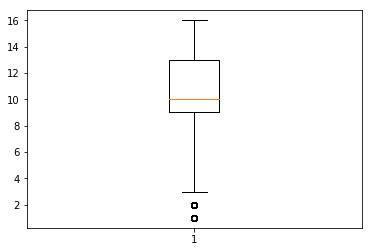

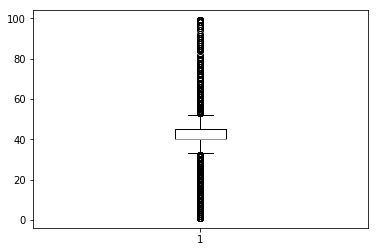

In [12]:
plt.boxplot(data['age'])
plt.show()

plt.boxplot(data['education-num'])
plt.show()

plt.boxplot(data['hours-per-week'])
plt.show()


Vemos que en hours-per-week y age tenemos outliers. Sobre todo en hours-per-week. Seguramente posteriormente haga limpieza de outliers para ajustar mejor los resultados de los modelos

In [13]:
data[['education_level', 'education-num']].head(50)

,education_level,education-num
0,Masters,14.0
1,Assoc-acdm,12.0
2,Doctorate,16.0
3,HS-grad,9.0
4,Some-college,10.0
5,Some-college,10.0
6,Some-college,10.0
7,HS-grad,9.0
8,Masters,14.0
9,Some-college,10.0


Efectivamente vemos que education_level y education-num representan los mismos datos. 

Por lo tanto eliminamos education_level del dataset

In [14]:
data = data.drop(['education_level'],axis=1)
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,14.0,Divorced,Sales,Unmarried,Other,Female,0.0,0.0,20.0,Peru,<=50K
1,43,Private,12.0,Divorced,Craft-repair,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
2,53,Private,16.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,99999.0,0.0,37.0,United-States,>50K
3,23,Private,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,3908.0,0.0,40.0,United-States,<=50K
4,32,Private,10.0,Divorced,Handlers-cleaners,Unmarried,Black,Male,0.0,0.0,40.0,Nicaragua,<=50K


### Feature Engineering

La variable objetivo la vamos a codificar. Cuando el valor sea <=50K podremos un -1 y cuando sea >50K sea 1

In [15]:
data['income'] = np.where(data['income'] == '<=50K',-1,1)
np.unique(data['income'], return_counts=True) # comprovamos que la conversión se ha hecho bien

(array([-1,  1]), array([27211,  8966]))

In [16]:
cols = data.columns[data.dtypes == 'object']
cols

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'native-country'],
      dtype='object')

Vamos a estudiar los valores de las variables categóricas

In [17]:
for col in cols:
    print(data[col].value_counts())

 Private             26572
 Self-emp-not-inc     3063
 Local-gov            2479
 State-gov            1576
 Self-emp-inc         1313
 Federal-gov          1156
 Without-pay            18
Name: workclass, dtype: int64
 Married-civ-spouse       16872
 Never-married            11683
 Divorced                  5059
 Separated                 1098
 Widowed                   1002
 Married-spouse-absent      442
 Married-AF-spouse           21
Name: marital-status, dtype: int64
 Prof-specialty       4839
 Craft-repair         4828
 Exec-managerial      4748
 Adm-clerical         4461
 Sales                4312
 Other-service        3810
 Machine-op-inspct    2403
 Transport-moving     1840
 Handlers-cleaners    1634
 Farming-fishing      1187
 Tech-support         1137
 Protective-serv       782
 Priv-house-serv       188
 Armed-Forces            8
Name: occupation, dtype: int64
 Husband           14984
 Not-in-family      9357
 Own-child          5299
 Unmarried          3812
 Wife        

**workclass** La mayoría de valores son de trabajadores por cuenta ajena. Creo que se podrían juntar por un lado los funcionarios (*-gov) y por otro lado los autónomos (self-emp*). Los desempleados son una muestra tan pequeña que quizá se pudan eliminar

**native-country** La mayoría de muestras corresponden a Estados Unidos. Seguramente sea aconsejable agrupar todos los valores que no son Estados Unidos en un solo valor. 

**race** Pasa parecido al pais. Casi todas las muestras son de raza blanca. Seguramente es aconsejable agrupar las muestras que no son raza blanca en un solo valor.

In [18]:
#workclass
data.loc[data.workclass.str.contains("gov"), 'workclass'] = 'Government'
data.loc[data.workclass.str.contains("Self"), 'workclass'] = 'Self'
data = data[~data.workclass.str.contains('Without-pay')]
print(data['workclass'].value_counts())

#race
data.loc[~data.race.str.contains("White"), 'race'] = 'non-White'
print(data['race'].value_counts())

#native-country
data.loc[~data['native-country'].str.contains("United-States"), 'native-country'] = 'non-United-States'
print(data['native-country'].value_counts())

 Private      26572
Government     5211
Self           4376
Name: workclass, dtype: int64
 White       31132
non-White     5027
Name: race, dtype: int64
 United-States       33015
non-United-States     3144
Name: native-country, dtype: int64


Como los datos no pertenecen a una serie temporal, vamos a codificar las variables categóricas de dos valores con LabelEncoder. Las de mas valores vamos a codificarlas con get_dummies

In [19]:
le = LabelEncoder()

cols_bin = ['race', 'sex', 'native-country']

for col in cols_bin:
    data[col] = le.fit_transform(data[col])



In [20]:
cols = ['workclass', 'marital-status', 'occupation', 'relationship']

for col in cols:
    dummy = pd.get_dummies(data[col])
    data = pd.concat([data,dummy],axis=1).drop([col],axis=1)


data.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,Private,...,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
0,49,14.0,1,0,0.0,0.0,20.0,1,-1,1,...,0,1,0,0,0,0,0,0,1,0
1,43,12.0,0,1,0.0,0.0,40.0,0,-1,1,...,0,0,0,0,0,1,0,0,0,0
2,53,16.0,0,0,99999.0,0.0,37.0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,23,9.0,0,0,3908.0,0.0,40.0,0,-1,1,...,0,0,0,0,0,0,0,0,0,1
4,32,10.0,1,1,0.0,0.0,40.0,1,-1,1,...,0,0,0,0,0,0,0,0,1,0


In [21]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36159.0,38.595232,13.223460,17.0,28.0,37.0,47.0,90.0
education-num,36159.0,10.114356,2.554035,1.0,9.0,10.0,13.0,16.0
race,36159.0,0.139025,0.345977,0.0,0.0,0.0,0.0,1.0
sex,36159.0,0.677065,0.467604,0.0,0.0,1.0,1.0,1.0
capital-gain,36159.0,1089.214884,7507.909494,0.0,0.0,0.0,0.0,99999.0
capital-loss,36159.0,88.124893,404.264633,0.0,0.0,0.0,0.0,4356.0
hours-per-week,36159.0,40.884980,11.977370,1.0,40.0,40.0,45.0,99.0
native-country,36159.0,0.086949,0.281765,0.0,0.0,0.0,0.0,1.0
income,36159.0,-0.504190,0.863605,-1.0,-1.0,-1.0,-1.0,1.0
Private,36159.0,0.734865,0.441411,0.0,0.0,1.0,1.0,1.0


#### Pintamos histogramas para cada clase

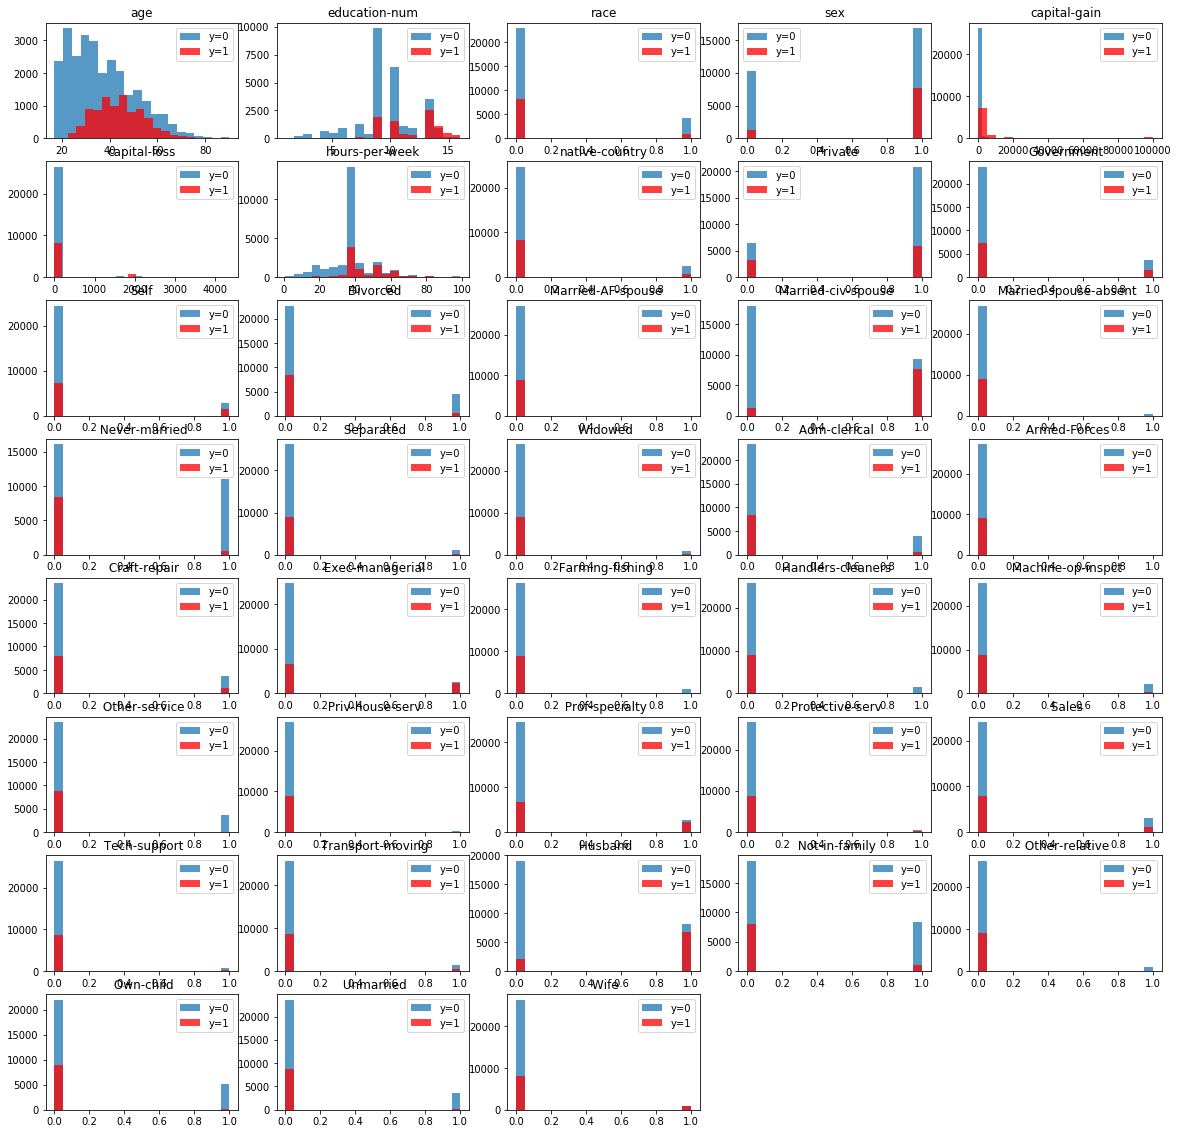

In [22]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['income'] == -1
idx_1 =  data['income'] == 1

# your code here
for i,feature in enumerate(data.columns.drop(['income'])):
    plt.subplot(8,5,i+1)   
    plt.hist(data.ix[idx_0,feature],density=0, bins = 20, alpha=0.75,label='y=0')
    plt.hist(data.ix[idx_1,feature],density=0, bins= 20, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

### Correlación entre variables

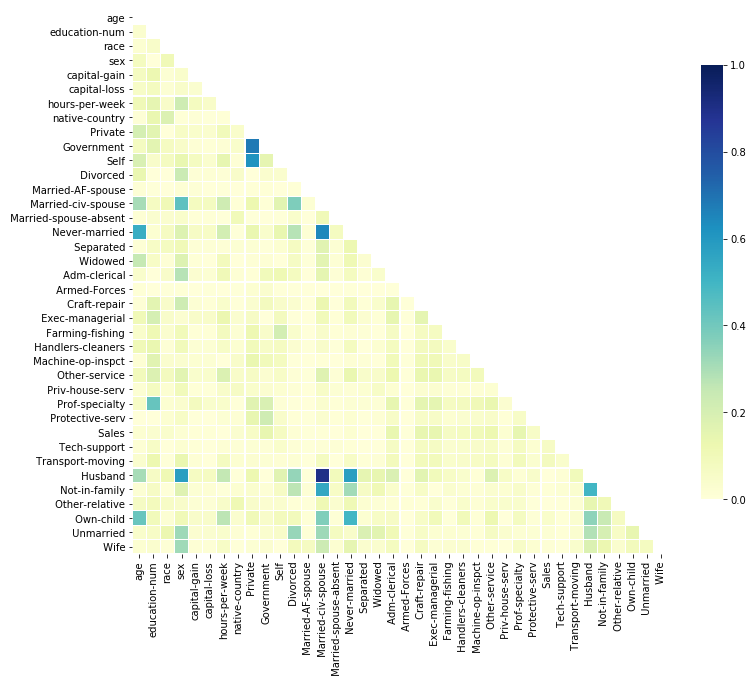

In [23]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['income'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Vemos una gran correlación entre Married-civ-spouse y husband. Tiene bastante lógica. De eliminar una eliminaría Married-civ-spouse que parece que tiene bastante correlación también con Never-married. Por ahora conservo todas. 

### División de variables.

In [24]:
# preparamos los datos
features = data.columns.drop(['income'])
X = data[features].values
y = data['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))

Datos train:  (27119, 38)
Datos test:   (9040, 38)
Propocion train:-0.504
Propocion test: -0.504


Voy a probar distintos modelos de clasificación, empezando por los más sencillos y terminando con los más complejos. 

### KNN

In [ ]:
vecinosIni = 10
vecinosFin = 20
nVecinos = range(vecinosIni, vecinosFin, 1)

param_grid = {'n_neighbors':  np.arange(vecinosIni, vecinosFin, 1)}

grid = GridSearchCV(KNeighborsClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 10).fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) 
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(nVecinos,scores,'-o')
plt.errorbar(nVecinos, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# vecinos')
plt.ylabel('10-Fold ACC')
plt.grid()
plt.show()

print("acc (train): {:.2f}".format(grid.score(X_train, y_train)))
print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

In [ ]:
y_pred = grid.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

Como podemos ver, pese a obtener un buen accuracy exactitud (0.85), el algoritmo no se comparta bien. La sensibilidad es muy baja. Probaremos ahora con regresión logistica


In [ ]:
vectorC = np.logspace(-3, , 20)
param_grid = {'C': vectorC}

grid = GridSearchCV(LogisticRegression(fit_intercept=False), scoring= 'accuracy', param_grid=param_grid, cv = 10)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.2f}".format(grid.score(X_test, y_test)))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(vectorC,scores,'-o')
plt.xlabel('C')
plt.ylabel('10-Fold ACC')
plt.show()

In [ ]:
y_pred = grid.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)